In [1]:
import os
import sys

def set_root_path():
    if os.getcwd().endswith('figures'): 
        os.chdir('../')
set_root_path()
sys.path.append('python/')
sys.path = [p for p in sys.path if "unbiased-inverse-volume-rendering" not in p]
print(os.getcwd())
print(sys.executable)
os.environ.pop("PYTHONPATH")

c:\Users\mayuf\source\repos\practical-inverse-rendering-of-textured-and-translucent-appearance
c:\Users\mayuf\anaconda3\envs\practical-inverse-rendering\python.exe


'C:\\Users\\mayuf\\source\\repos\\unbiased-inverse-volume-rendering\\mitsuba3\\build\\Release\\python'

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import mitsuba as mi
import drjit as dr
import numpy as np

from practical_reconstruction import figutils
from practical_reconstruction import scene_configuration
from practical_reconstruction import io_utils
from practical_reconstruction import optimization_cli
from core import integrators
from core import bsdfs
from core import textures

mi.set_variant("cuda_ad_rgb")

from core import integrators
from core import bsdfs
from core import textures
from core import emitters

integrators.register()
bsdfs.register()
textures.register()
emitters.register()

In [3]:
def load_modified_scene(scene_config, res=[400, 240]):
  os.makedirs(scene_config.result_folder,exist_ok=True)

  tmp_mitsuba_xml = io_utils.mitsuba_remote_to_local(scene_config,override=True)
  scene = mi.load_file(tmp_mitsuba_xml)
  params = mi.traverse(scene)

  params.update()
  return scene

In [4]:
def update_light_position(params, camera_idx, light_idx):
    light_positions = [
        ["-6.500000 0.000000 0.000000 0.300000 0.000001 9.396926 0.171010 -0.840401 -0.000001 3.420202 -0.469846 18.293852 0.000000 0.000000 0.000000 1.000000"],
        ["-6.500000 0.000002 -0.000000 0.300000 0.000001 9.396926 -0.171010 12.840401 -0.000000 -3.420202 -0.469846 18.293852 0.000000 0.000000 0.000000 1.000000"],
        ["-6.351649 0.331862 -0.104910 4.496384 -0.000001 9.877216 0.078112 2.875512 1.380779 1.526588 -0.482589 18.803574 0.000000 0.000000 0.000000 1.000000"],
        ["-6.351649 -1.094468 -0.091031 3.941252 0.000001 8.570578 -0.257610 16.304405 1.380778 -5.034614 -0.418748 16.249941 0.000000 0.000000 0.000000 1.000000"],
        ["-6.495393 -0.257781 0.013717 -0.248695 0.000000 7.287663 0.342381 -7.695252 -0.244695 6.842771 -0.364125 14.064992 0.000000 0.000000 0.000000 1.000000"],
        ["-6.495393 -0.021125 0.018793 -0.451723 0.000000 9.984242 0.028058 4.877662 -0.244695 0.560771 -0.498858 19.454330 0.000000 0.000000 0.000000 1.000000"],
        ["-6.168086 0.130222 0.157600 -6.003979 -0.000001 9.991476 -0.020640 6.825583 -2.050541 -0.391715 -0.474064 18.462549 0.000000 0.000000 0.000000 1.000000"],
        ["-6.168086 2.125814 0.116543 -4.361718 -0.000001 7.388578 -0.336931 19.477226 -2.050541 -6.394516 -0.350564 13.522580 0.000000 0.000000 0.000000 1.000000"],
        ["-5.463686 2.329839 -0.244523 10.080907 0.000000 9.027852 0.215046 -2.601838 3.521098 3.615210 -0.379426 14.677032 0.000000 0.000000 0.000000 1.000000"],
        ["-5.463686 -1.358760 -0.262195 10.787793 0.000001 9.680313 -0.125415 11.016590 3.521098 -2.108389 -0.406848 15.773907 0.000000 0.000000 0.000000 1.000000"],
        ["-5.470313 -3.396298 0.209990 -8.099610 -0.000001 7.775657 0.314401 -6.576035 -3.510794 5.291910 -0.327194 12.587777 0.000000 0.000000 0.000000 1.000000"],
        ["-5.470313 0.097866 0.270017 -10.500671 -0.000000 9.998359 -0.009060 6.362389 -3.510794 -0.152489 -0.420724 16.328970 0.000000 0.000000 0.000000 1.000000"],
        ["-6.340923 -0.726069 -0.103774 4.450963 -0.000001 9.439081 -0.165104 12.604167 1.429231 -3.221269 -0.460404 17.916149 0.000000 0.000000 0.000000 1.000000"],
        ["-6.340923 -1.890293 -0.056160 2.546408 0.000001 5.108218 -0.429843 23.193733 1.429231 -8.386471 -0.249160 9.466407 0.000000 0.000000 0.000000 1.000000"],
        ["-5.923949 3.505302 -0.107843 4.613736 -0.000001 5.240549 0.425842 -11.033693 2.675224 7.762055 -0.238806 9.052226 0.000000 0.000000 0.000000 1.000000"],
        ["-5.923949 1.298811 -0.195271 8.110845 0.000000 9.489015 0.157786 -0.311451 2.675224 2.876054 -0.432403 16.796135 0.000000 0.000000 0.000000 1.000000"],
        ["-4.525468 -0.664377 0.357371 -13.994832 0.000000 9.957076 0.046277 4.148911 -4.665848 0.644388 -0.346619 13.364748 0.000000 0.000000 0.000000 1.000000"],
        ["-4.525469 4.085328 0.295114 -11.504583 0.000001 8.222492 -0.284564 17.382553 -4.665847 -3.962414 -0.286236 10.949423 0.000000 0.000000 0.000000 1.000000"],
        ["-4.304458 0.367734 -0.374201 15.268055 -0.000000 9.987950 0.024538 5.018463 4.870486 0.324998 -0.330713 12.728526 0.000000 0.000000 0.000000 1.000000"],
        ["-4.304460 -4.528938 -0.298474 12.238949 -0.000001 7.966673 -0.302209 18.088356 4.870486 -4.002604 -0.263786 10.051451 0.000000 0.000000 0.000000 1.000000"],
        ["-5.629382 -4.598324 0.098103 -3.624103 -0.000000 3.924556 0.459885 -12.395420 -3.249624 7.965756 -0.169945 6.297793 0.000000 0.000000 0.000000 1.000000"],
        ["-5.629382 -2.261339 0.222938 -8.617526 -0.000000 8.918556 0.226160 -3.046399 -3.249624 3.917358 -0.386200 14.947990 0.000000 0.000000 0.000000 1.000000"],
        ["-5.920269 2.234655 0.173556 -6.642261 0.000001 8.408242 -0.270654 16.826164 -2.683360 -4.930292 -0.382916 14.816631 0.000000 0.000000 0.000000 1.000000"],
        ["-5.920269 3.943043 0.061132 -2.145266 0.000001 2.961628 -0.477569 25.102751 -2.683360 -8.699492 -0.134874 4.894962 0.000000 0.000000 0.000000 1.000000"],
        ["-3.675665 5.887233 -0.288803 11.852130 -0.000001 7.003352 0.356907 -8.276285 5.360922 4.036527 -0.198015 7.420607 0.000000 0.000000 0.000000 1.000000"],
        ["-3.675665 0.797100 -0.410448 16.717928 -0.000001 9.953188 0.048323 4.067064 5.360922 0.546525 -0.281420 10.756795 0.000000 0.000000 0.000000 1.000000"],
        ["4.302106 2.510774 0.353164 -13.826547 -0.000000 9.422405 -0.167469 12.698742 -4.872565 2.216823 0.311817 -12.972672 0.000000 0.000000 0.000000 1.000000"],
        ["4.302105 6.463549 0.189844 -7.293776 0.000001 5.065047 -0.431119 23.244743 -4.872565 5.706823 0.167618 -7.204730 0.000000 0.000000 0.000000 1.000000"],
        ["3.592300 3.445053 -0.379434 15.477367 0.000000 9.105629 0.206685 -2.267411 5.417138 -2.284540 0.251617 -10.564665 0.000000 0.000000 0.000000 1.000000"],
        ["3.592301 -2.238846 -0.401385 16.355413 -0.000000 9.632412 -0.134319 11.372764 5.417137 1.484661 0.266173 -11.146930 0.000000 0.000000 0.000000 1.000000"],
        ["4.405418 -5.563057 0.240401 -9.316023 0.000000 6.538967 0.378292 -9.131679 -4.779361 -5.127797 0.221591 -9.363658 0.000000 0.000000 0.000000 1.000000"],
        ["4.405419 -1.171019 0.362951 -14.218028 0.000000 9.872366 0.079630 2.814793 -4.779360 -1.079397 0.334553 -13.882127 0.000000 0.000000 0.000000 1.000000"],
        ["6.349392 -1.058252 -0.093012 4.020483 -0.000000 8.691961 -0.247234 15.889346 1.391121 4.830105 0.424528 -17.481133 0.000000 0.000000 0.000000 1.000000"],
        ["6.349392 -2.006408 -0.037240 1.789593 -0.000000 3.480054 -0.468746 24.749849 1.391121 9.157704 0.169971 -7.298844 0.000000 0.000000 0.000000 1.000000"],
        ["5.611467 4.313691 -0.130986 5.539443 -0.000001 5.190787 0.427363 -11.094528 3.280463 -7.378875 0.224061 -9.462442 0.000000 0.000000 0.000000 1.000000"],
        ["5.611467 1.620554 -0.238980 9.859218 -0.000000 9.470449 0.160551 -0.422023 3.280463 -2.772074 0.408793 -16.851728 0.000000 0.000000 0.000000 1.000000"],
        ["4.724389 -1.114659 0.338856 -13.254258 -0.000000 9.867426 0.081147 2.754136 -4.464319 -1.179595 0.358597 -14.843865 0.000000 0.000000 0.000000 1.000000"],
        ["4.724389 3.502377 0.295404 -11.516143 -0.000000 8.602087 -0.254971 16.198841 -4.464320 3.706407 0.312612 -13.004497 0.000000 0.000000 0.000000 1.000000"],
        ["5.144022 0.275446 -0.305347 12.513867 0.000000 9.989844 0.022529 5.098841 3.973542 -0.356585 0.395292 -16.311687 0.000000 0.000000 0.000000 1.000000"],
        ["5.144022 -3.714458 -0.242762 10.010472 0.000000 7.942291 -0.303809 18.152367 3.973542 4.808619 0.314272 -13.070869 0.000000 0.000000 0.000000 1.000000"],
        ["6.284044 -2.083320 0.074064 -2.662562 0.000000 5.794742 0.407495 -10.299814 -1.661562 -7.879133 0.280111 -11.704434 0.000000 0.000000 0.000000 1.000000"],
        ["6.284044 -0.643767 0.123693 -4.647718 0.000000 9.677689 0.125920 0.963192 -1.661563 -2.434731 0.467808 -19.212315 0.000000 0.000000 0.000000 1.000000"],
        ["6.310709 0.435642 0.117789 -4.411574 0.000000 9.833279 -0.090921 9.636825 -1.557224 1.765458 0.477346 -19.593838 0.000000 0.000000 0.000000 1.000000"],
        ["6.310709 1.847992 0.076231 -2.749225 0.000000 6.363876 -0.385685 21.427387 -1.557224 7.489059 0.308928 -12.857102 0.000000 0.000000 0.000000 1.000000"],
        ["5.828282 2.336207 -0.188032 7.821288 -0.000000 8.494363 0.263846 -4.553823 2.877695 -4.731590 0.380827 -15.733091 0.000000 0.000000 0.000000 1.000000"],
        ["5.828282 -0.627658 -0.219125 9.065010 0.000000 9.898993 -0.070886 8.835443 2.877696 1.271213 0.443801 -18.252039 0.000000 0.000000 0.000000 1.000000"],
        ["6.010379 -1.710559 0.170087 -6.503482 0.000000 8.934071 0.224624 -2.984961 -2.474943 -4.154078 0.413055 -17.022202 0.000000 0.000000 0.000000 1.000000"],
        ["6.010379 0.876233 0.185271 -7.110822 -0.000000 9.731606 -0.115064 10.602539 -2.474943 2.127925 0.449928 -18.497122 0.000000 0.000000 0.000000 1.000000"],
        ["6.428964 0.151013 -0.073331 3.233233 -0.000000 9.947407 0.051213 3.951496 0.958341 -1.013058 0.491935 -20.177393 0.000000 0.000000 0.000000 1.000000"],
        ["6.428964 -0.827041 -0.061028 2.741125 -0.000000 8.278531 -0.280472 17.218893 0.958341 5.548147 0.409403 -16.876122 0.000000 0.000000 0.000000 1.000000"],
        ["6.500000 0.000000 0.000000 0.300000 0.000000 9.396926 0.171010 -0.840401 0.000000 -3.420202 0.469846 -19.293852 0.000000 0.000000 0.000000 1.000000"],
        ["6.500000 0.000000 0.000000 0.300000 0.000000 9.396926 -0.171010 12.840401 0.000000 3.420201 0.469846 -19.293852 0.000000 0.000000 0.000000 1.000000"],
    ]
    raw_string = light_positions[camera_idx * 2 + light_idx][0]
    float_values = list(map(float, raw_string.strip().split()))
    matrix_4x4 = np.array(float_values).reshape((4, 4))
    params['arealight.to_world'] = mi.Transform4f(matrix_4x4)
    params.update()

def save_images(scene, params, dir, spp):
    print("start rendering")
    for i, sensor in enumerate(scene.sensors()):
      for j in range(2):
        update_light_position(params, i, j)
        image = mi.render(scene, sensor=sensor, spp=spp)
        bitmap = mi.Bitmap(image).convert(
            pixel_format=mi.Bitmap.PixelFormat.RGB,
            component_format=mi.Struct.Type.UInt8,
            srgb_gamma=True
        )
        png_path = dir / f"view_{i:02d}_{j:02d}.png"
        bitmap.write(str(png_path))

        bitmap = mi.Bitmap(image).convert(
                pixel_format=mi.Bitmap.PixelFormat.RGB,
                component_format=mi.Struct.Type.Float32,
                srgb_gamma=False
        )
        exr_path = dir / f"view_{i:02d}_{j:02d}.exr"
        bitmap.write(str(exr_path))
        print(f"saving: {i}")
    print(f"Saved: {dir}")

Scene[
  children = [
    HDRFilm[
      size = [436, 260],
      crop_size = [436, 260],
      crop_offset = [0, 0],
      sample_border = 0,
      compensate = 0,
      filter = BoxFilter[],
      file_format = OpenEXR,
      pixel_format = rgb,
      component_format = float32,
    ],
    IndependentSampler[
      base_seed = 0
      sample_count = 4
      samples_per_wavefront = 1
      wavefront_size = 0
    ],
    Rectangle[
      to_world = [[-6.5, 0, 0, 0.3],
                  [1e-06, 9.39693, 0.17101, -0.840401],
                  [-1e-06, 3.4202, -0.469846, 18.2939],
                  [0, 0, 0, 1]],
      frame = Frame[
        s=[[-13, 2e-06, -2e-06]],
        t=[[0, 18.7939, 6.8404]],
        n=[[1.97187e-07, 0.34202, -0.939693]]
      ],
      surface_area = [260],
      bsdf = SmoothDiffuse[
        reflectance = UniformSpectrum[value=[0]]
      ],
      emitter = AreaLight[
        radiance = SRGBReflectanceSpectrum[
          value = [[1, 1, 1]]
        ],
        surfa

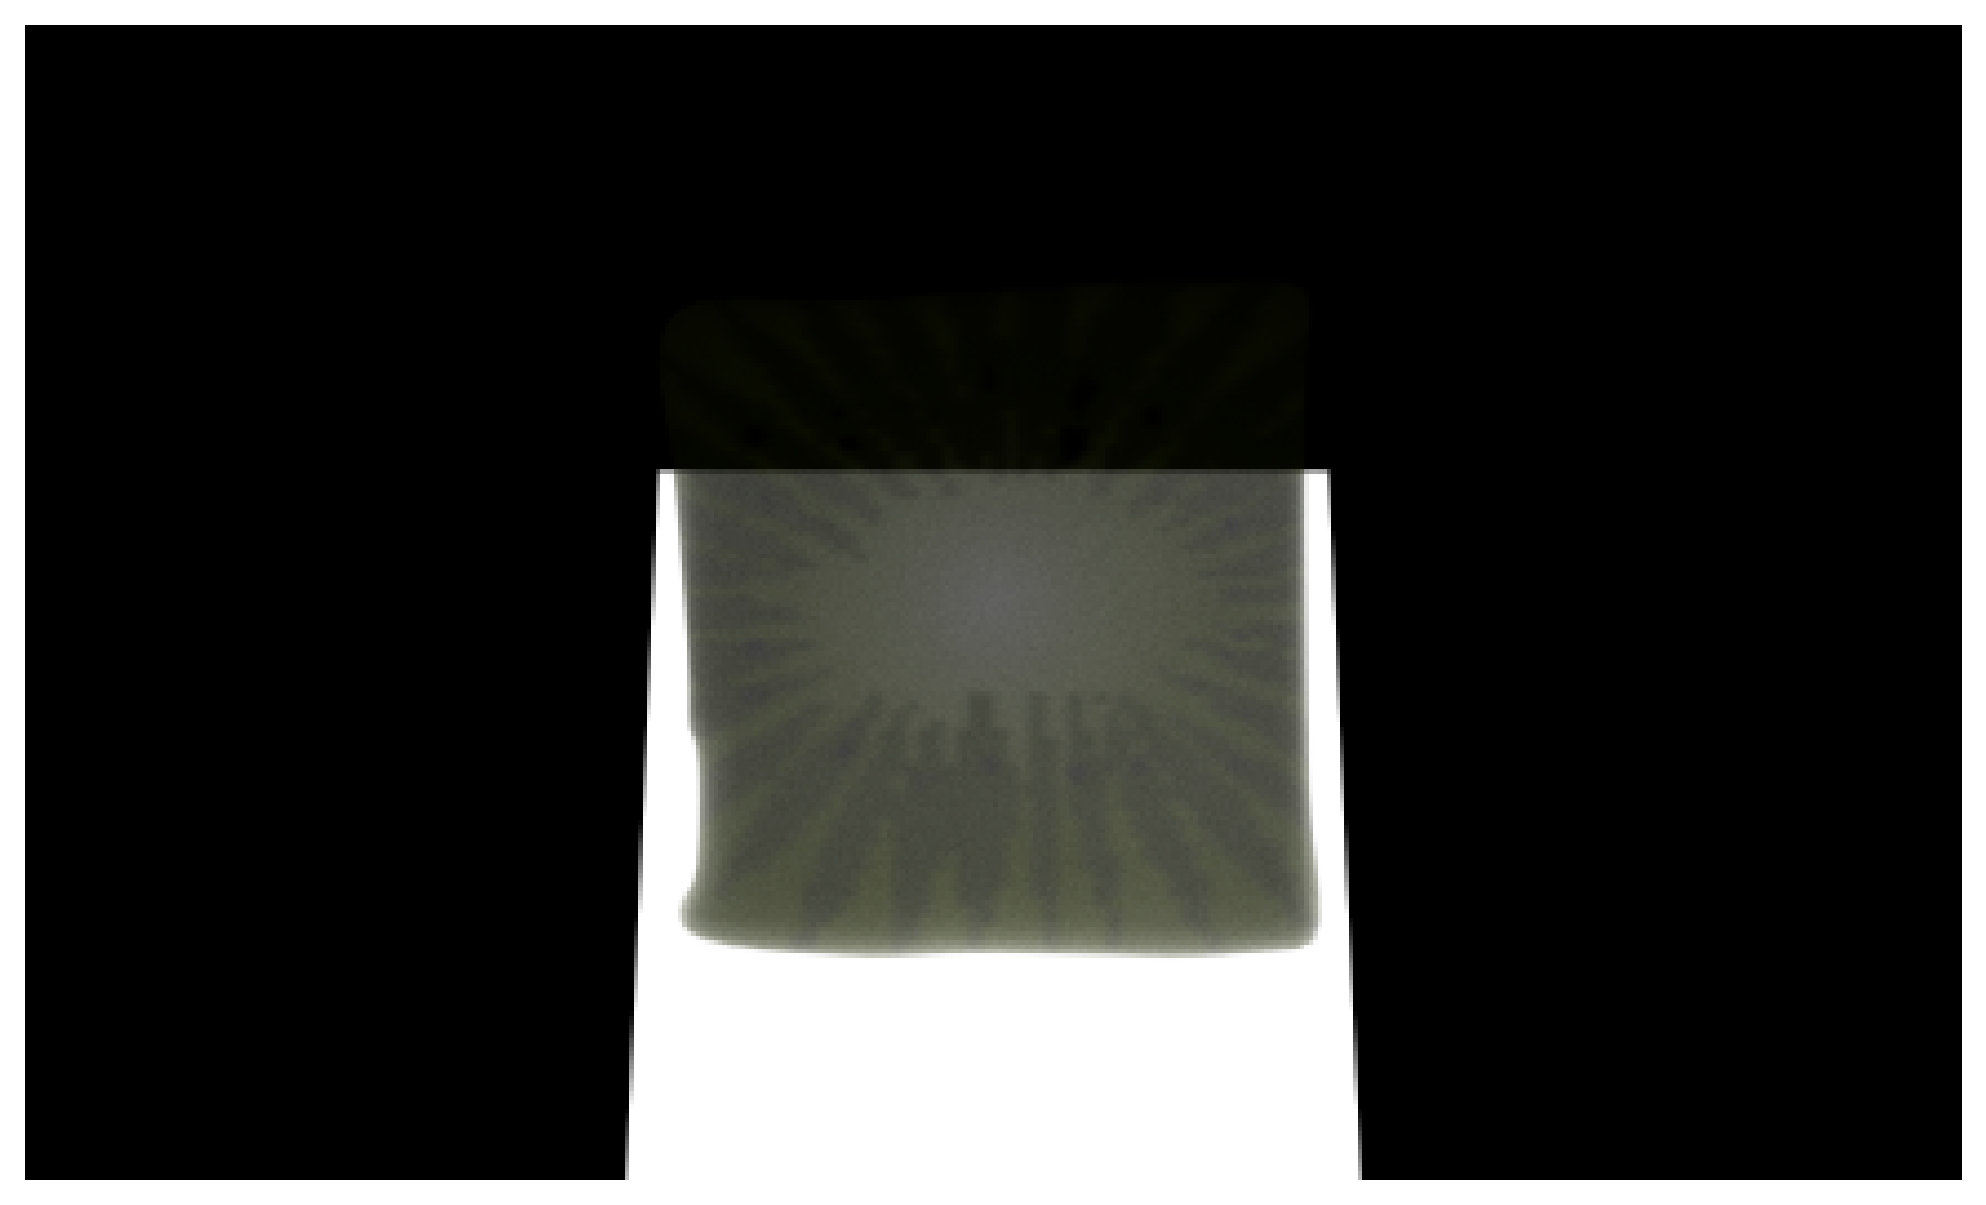

In [5]:
# Display reference image
scene_name = 'kiwi_refine'
technique = 'mipmap_pyramid'
result_folder = f'results/{scene_name}/{technique}'
scene_folder = f'third_party/{scene_name}'
result_folder += '_test'

override_bindings = []
override_bindings.append(f"SceneConfig.result_folder='{result_folder}'")
override_bindings.append(f"SceneConfig.scene_folder='{scene_folder}'")
override_bindings.append(f'SceneConfig.base_learning_rate={0.1}')
scene_config = scene_configuration.SceneConfig.get_instance(
				f'{scene_name}/{technique}', override_bindings, sss_config=True
)

scene = load_modified_scene(scene_config,res=[800,480])
ref_spp=4096
opt_spp=128

ref_dir=Path("third_party/kiwi_refine/references")
params = mi.traverse(scene)
#save_images(scene, params, ref_dir, ref_spp)

ref_images=[]
for i, sensor in enumerate(scene.sensors()):
    for j in range(2):
        exr_path = ref_dir / f"view_{i:02d}_{j:02d}.exr"
        bmp = mi.Bitmap(str(exr_path))
        tensor = mi.TensorXf(bmp)
        ref_image = mi.Bitmap(tensor)
        ref_images.append(tensor)
        
print(scene)
plt.figure(figsize=(10,6))
plt.imshow(np.clip(ref_images[0], 0, 1))  # 値を0-1にクリップ
plt.axis("off")
plt.show()

In [6]:
if technique == 'gradient_filtering':
    gin_config_name = f'{scene_name}/naive'
else:
    gin_config_name = f'{scene_name}/{technique}'

print(f'Next result location: {result_folder}')

print(scene_config)
optimization_cli.run_config(gin_config_name, override_bindings, sss_config=True)

Next result location: results/kiwi_refine/mipmap_pyramid_test
SceneConfig(approach=<Approach.MIPMAP_PYRAMID: 2>, scene_setup=<Setup.OLAT: 1>, random_lights=0, random_sensors=False, envmap_rotations=[0.0, 45.0], extra_render_resolutions=[], scene_name='kiwi_refine', scene_folder='third_party/kiwi_refine', result_folder='results/kiwi_refine/mipmap_pyramid_test', tmp_folder='tmp/kiwi_refine', n_resolutions=1, n_texture_scales=1, optimized_path_depth=-1, rerender_spp=8192, samples_per_pixel_primal=128, samples_per_pixel_gradient=6, base_learning_rate=0.1, beta_1=0.9, use_sgd=False, mask_updates=False, use_mitsuba_reference=True, reference_scaling=1.0, reference_spp=1024, optimized_sensors_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], optimized_shapes=['slice'], per_material_learning_rates=defaultdict(<function SceneConfig.__post_init__.<locals>.<lambda> at 0x0000021C4D1416C0>, {'mat-kiwi': defaultdict(<function SceneConfig.__post_in

RuntimeError: ​[xml.cpp:1082] Error while loading "tmp\kiwi_refine\mts_scene\kiwi_refine_modified.xml" (near line 485, col 24): could not instantiate emitter plugin of type "switchemitter": 
[xml.cpp:1082]   [PluginManager] Plugin "switchemitter" not found!

In [ ]:
# Figure setup

def figure_grid_setup(
    fig_width,
    image_shape,
    image_crop_shape,
    inner_hspace=0.0,
    inner_wspace=0.0,
    outer_space=0.1,
):
  # Image aspect ratios
  h, w = image_shape
  h_crop, w_crop = image_crop_shape
  r = w / h
  r_crop = w_crop / h_crop

  # Spacing in the inner gridspec
  inner_wspace = inner_hspace
  # same vertical spacing as horizontal spacing
  inner_hspace = inner_wspace
  inner_rows = 2
  inner_cols = 3
  inner_height_ratios = [h_crop, h_crop]
  inner_width_ratios = [w_crop, w_crop, w_crop]
  inner_aspect = figutils.gridspec_aspect(
      n_rows=inner_rows,
      n_cols=inner_cols,
      w=inner_width_ratios,
      h=inner_height_ratios,
      wspace=inner_wspace,
      hspace=inner_hspace,
  )
  # Spacing in the main griddpec
  outer_rows = 2
  outer_cols = 1
  outer_wspace = 0
  outer_hspace = outer_space
  # If width is 1, we need the sum of the inverses for the height (single column)
  # If height is 1, we need the sum for the width (single row)
  outer_aspect = figutils.gridspec_aspect(
      n_rows=outer_rows,
      n_cols=outer_cols,
      w=[1],
      h=[1 / inner_aspect, 1 / r],
      wspace=outer_wspace,
      hspace=outer_hspace,
  )
  outer_aspect *= 0.98

  fig = plt.figure(1, figsize=(fig_width, fig_width / outer_aspect))

  outer_gs = fig.add_gridspec(
      outer_rows,
      outer_cols,
      hspace=outer_hspace,
      wspace=outer_wspace,
      height_ratios=[1 / inner_aspect, 1 / r],
      width_ratios=[1],
  )

  inner_gs = gridspec.GridSpecFromSubplotSpec(
      inner_rows,
      inner_cols,
      subplot_spec=outer_gs[0],
      wspace=inner_wspace,
      hspace=inner_hspace,
      width_ratios=inner_width_ratios,
      height_ratios=inner_height_ratios,
  )
  return (
      fig,
      outer_gs,
      inner_gs,
      inner_rows,
      inner_cols,
  )

In [ ]:
FIGURE_DIR = "figures/pdfs"
FIGURE_NAME = "volume_gradients"

ref_crop_offset = (26, 22)
ref_crop_size = (739, 432)

grad_crop_offset = (18, 13)
grad_crop_size = (363, 215)

cropped_ref_image = figutils.crop_image(ref_image,ref_crop_offset,ref_crop_size)
cropped_forward_images = [figutils.crop_image(im,grad_crop_offset,grad_crop_size) for im in forward_images]
cropped_fd_images = [figutils.crop_image(im,grad_crop_offset,grad_crop_size) for im in fd_images]

titles = [
    "Albedo",
    "Extinction",
    "Phase function (HG)",
    r"\textsc{Dragon}",
]
row_titles = ["Our forward", "Finite diff."]

params_label = [
    r"$\rho=[0.2, 0.4, 0.95]$",
    r"$\sigma_t=[15,7,5]$",
    r"$g=[-0.5, -0.2, 0.1]$",
]

(
    fig,
    outer_gs,
    inner_gs,
    inner_rows,
    inner_cols,
) = figure_grid_setup(
    figutils.COLUMN_WIDTH,
    ref_image.shape[:2],
    cropped_forward_images[0].shape[:2],
    inner_hspace=0.02,
    inner_wspace=0.02,
    outer_space=0.0,
)

title_pad = 3
label_pad = 2
line_width = 0.75

strengths = [4.5, 4.5, 4.5]
# Grads
if True:
  for row in range(inner_rows):
    for col in range(inner_cols):
      ax = fig.add_subplot(inner_gs[row, col])
      figutils.disable_ticks(ax)
      if col == 0:
        ax.set_ylabel(row_titles[row], labelpad=label_pad)
      # Our
      if row == 0:
        ax.set_title(titles[col], pad=title_pad)
        im = ax.imshow(
            cropped_forward_images[col],
            cmap=cm.coolwarm,
            vmin=-forward_vlims[col] * strengths[col],
            vmax=forward_vlims[col] * strengths[col],
        )
      elif row == 1:
        im = ax.imshow(
            cropped_fd_images[col],
            cmap=cm.coolwarm,
            vmin=-forward_vlims[col] * strengths[col],
            vmax=forward_vlims[col] * strengths[col],
        )

# Reference
if True:
  ax = fig.add_subplot(outer_gs[1])
  im = ax.imshow(cropped_ref_image)
  ax.set_ylabel(titles[-1], labelpad=label_pad)
  # ax.set_title(r"\vspace{250px}" + r"\;\;\;\;\;\;\;\;\;".join(params_label),pad=0)
  ax.set_xlabel(r"\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;".join(params_label),labelpad=label_pad)
  figutils.disable_ticks(ax)

  ax = fig.add_subplot(outer_gs[0])
  ax.axis('off')
  # Create an inset axes
  inset = inset_axes(
      ax,  # Parent axes
      width="1%",  # Width of the inset in percentage of the parent axis
      height="99.19%",  # Height of the inset in percentage of the parent axis
      loc="lower left",  # Location inside the parent axis
      bbox_to_anchor=(1.005, 0.005, 1, 1),  # Bounding box adjustment
      bbox_transform=ax.transAxes,  # Use axes coordinates
      borderpad=0,
  )  # Padding

  # Create the colorbar
  cbar = fig.colorbar(
      cm.ScalarMappable(
          norm=Normalize(
              vmin=-np.max(forward_vlims), vmax=np.max(forward_vlims)
          ),
          cmap=cm.coolwarm,
      ),
      cax=inset,
      orientation="vertical",
  )
  cbar.ax.yaxis.set_label_position("left")  # Move label to the left
  # cbar.ax.yaxis.tick_left()  # Move ticks to the left side
  cbar.set_label("Parameter gradient", labelpad=-9)
  ticks = [cbar.vmin, cbar.vmax]
  cbar.set_ticks(ticks)
  # cbar.set_ticklabels([f"{x:.2f}" for x in ticks])
  cbar.set_ticklabels(["neg", "pos"])
  cbar.ax.tick_params(pad=1.8, length=0)

# fig.tight_layout()
figutils.force_post_crop_size(fig, figutils.COLUMN_WIDTH)

In [ ]:
figutils.savefig(
    fig,
    name=Path(FIGURE_NAME),
    fig_directory=Path(FIGURE_DIR),
    dpi=300,
    pad_inches=0.005,
    bbox_inches="tight",
    compress=False,
    target_width=figutils.COLUMN_WIDTH,
    backend=None,
)